<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Started

We'll start by importing the packages we'll need in this notebook.  They're mostly the same as the ones we've used in the previous notebooks.

In [1]:
import pathlib
import random
import shutil
import sys
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import ultralytics
import yaml
from IPython import display
from PIL import Image
from tqdm.notebook import tqdm
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In case we want to reproduce this notebook in the future, we'll record the version information. 

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", Image.__version__)
print("PyYAML version:", yaml.__version__)
print("torch version:", torch.__version__)
print("ultralytics version:", ultralytics.__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
matplotlib version: 3.9.2
pandas version: 2.2.3
PIL version: 10.2.0
PyYAML version: 6.0.2
torch version: 2.2.2+cu121
ultralytics version: 8.3.27


This notebook will require a GPU to run in any reasonable amount of time.  Check that the device is `cuda`.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using cuda device.


### Data Transformation

Much of the work in this lesson will be getting all of the annotation data in the format that YOLO expects it.  Once that's done, we can relax while the computer runs many epochs of training.

In a previous lesson, we arranged the Dhaka AI data set in the `data_images` directory.  Here's the structure:

In [4]:
!tree data_images --filelimit=10

data_images
├── test [500 entries exceeds filelimit, not opening dir]
└── train
    ├── annotations [3003 entries exceeds filelimit, not opening dir]
    └── images [3003 entries exceeds filelimit, not opening dir]

4 directories, 0 files


**Task 3.4.1:** Set the directories for the training images and annotations as variables.

In [5]:
training_dir = pathlib.Path("data_images", "train")
images_dir = training_dir / "images"
annotations_dir = training_dir / "annotations"

print("Images     :", images_dir)
print("Annotations:", annotations_dir)

Images     : data_images/train/images
Annotations: data_images/train/annotations


Let's remind ourselves what the annotation XML files look like.  This next cell will print out the first 25 lines of the first annotation file.

In [6]:
!head -n 25 $annotations_dir/01.xml

<annotation>
	<folder>Images</folder>
	<filename>02_Motijheel_280714_0005.jpg</filename>
	<path>E:\Datasets\Dataset\Images\02_Motijheel_280714_0005.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1200</width>
		<height>800</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bus</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>833</xmin>
			<ymin>390</ymin>
			<xmax>1087</xmax>
			<ymax>800</ymax>
		</bndbox>
	</object>


Each detected object is described in an `<object>` tag.  The `<name>` tag gives us the class of the object, and the `<bndbox>` gives the upper-left and lower-right corners  of the bounding box.  This is a sensible and readable format.

Unfortunately, this is not the format that YOLO needs.  The YOLO format is a text file, with each object being a line of the format
```
class_index x_center y_center width height
```
where `class_index` is a number assigned to class.  The bounding box is centered at (`x_center`, `y_center`), with a size of `width`$\times$`height`.  All of these dimensions are given as a fraction of the image size, rather than in pixels.  These are called _normalized_ coordinates.

Let's start by assigning the class indices.  We happen to know that these are the classes in this data set:

In [7]:
classes = [
    "ambulance",
    "army vehicle",
    "auto rickshaw",
    "bicycle",
    "bus",
    "car",
    "garbagevan",
    "human hauler",
    "minibus",
    "minivan",
    "motorbike",
    "pickup",
    "policecar",
    "rickshaw",
    "scooter",
    "suv",
    "taxi",
    "three wheelers (CNG)",
    "truck",
    "van",
    "wheelbarrow",
]

<div class="alert alert-info" role="alert">
A puzzle for you to consider: If we didn't know that these were the classes in this data set, how would you have found this list?
</div>

**Task 3.4.2:** Generate a dictionary that maps the classes names to their indices.

In [8]:
class_mapping = {cls: idx for idx, cls in enumerate(classes) }

print(class_mapping)

{'ambulance': 0, 'army vehicle': 1, 'auto rickshaw': 2, 'bicycle': 3, 'bus': 4, 'car': 5, 'garbagevan': 6, 'human hauler': 7, 'minibus': 8, 'minivan': 9, 'motorbike': 10, 'pickup': 11, 'policecar': 12, 'rickshaw': 13, 'scooter': 14, 'suv': 15, 'taxi': 16, 'three wheelers (CNG)': 17, 'truck': 18, 'van': 19, 'wheelbarrow': 20}


Let's work out the bounding box transformation "by hand" first.  We'll use the object we saw above as an example.

In [9]:
width = 1200
height = 800
xmin = 833
ymin = 390
xmax = 1087
ymax = 800

**Task 3.4.3:** Compute the center of the bounding box.  We take it to be halfway between the min and max values.  We also need to divide by the width or height as appropriate, to measure it in a fraction of the image size.

In [10]:
x_center = ((xmin+xmax)/2) / width
y_center = (ymin+ymax)/2 / height

print(f"Bounding box center: ({x_center}, {y_center})")

Bounding box center: (0.8, 0.74375)


<div class="alert alert-info" role="alert">
Sanity check: Consider the $y$ coordinates.  Does this value for center make sense?
</div>

**Task 3.4.4:** Compute the width and height of the bounding box.  Again, measure it as a fraction of the width or height of the whole image.

In [11]:
bb_width = (xmax-xmin) / width
bb_height = (ymax-ymin) / height

print(f"Bounding box size: {bb_width:0.3f} ⨯ {bb_height:0.3f}")

Bounding box size: 0.212 ⨯ 0.512


<div class="alert alert-info" role="alert">
Sanity check: Consider the height.  Does this value make sense?
</div>

**Task 3.4.5:** Encapsulate this code in a function.

In [12]:
def xml_to_yolo_bbox(bbox, width, height):
    """Convert the XML bounding box coordinates into YOLO format.

    Input:  bbox    The bounding box, defined as [xmin, ymin, xmax, ymax],
                    measured in pixels.
            width   The image width in pixels.
            height  The image height in pixels.

    Output: [x_center, y_center, bb_width, bb_height], where the bounding
            box is centered at (x_center, y_center) and is of size
            bb_width x bb_height.  All values are measured as a fraction
            of the image size."""

    xmin, ymin, xmax, ymax = bbox
    x_center = ((xmin+xmax)/2) / width
    y_center = (ymin+ymax)/2 / height

    bb_width = (xmax-xmin) / width
    bb_height = (ymax-ymin) / height

    return [x_center, y_center, bb_width, bb_height]


xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

[0.8, 0.74375, 0.21166666666666667, 0.5125]

**Task 3.4.6:** Write a function to parse all of the objects in an XML file.  Much of the code comes from a previous lesson.  We need to add code to look up the class index from the class name.

In [14]:
def parse_annotations(f):
    """Parse all of the objects in a given XML file to YOLO format.

    Input:  f      The path of the file to parse.

    Output: A list of objects in YOLO format.
            Each object is a list [index, x_center, y_center, width, height]."""

    objects = []

    tree = ET.parse(f)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = class_mapping[label]
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        yolo_bbox = xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

        objects.append([class_id] + yolo_bbox)

    return objects


objects = parse_annotations(annotations_dir / "01.xml")
print("First object:", objects[0])

First object: [4, 0.8, 0.74375, 0.21166666666666667, 0.5125]


In [15]:
classes[4]

'bus'

**Task 3.4.7:** Write a function that outputs the YOLO objects in the text format.  Each object should be on its own line, with spaces between the components.

In [16]:
def write_label(objects, filename):
    """Write the annotations to a file in the YOLO text format.

    Input:  objects   A list of YOLO objects, each a list of numbers.
            filename  The path to write the text file."""

    with open(filename, "w") as f:
        for obj in objects:
            # Write the object out as space-separated values
            f.write(" ".join(str(x) for x in obj))
            # Write a newline
            f.write("\n")

We'll test this on the objects we've parsed.  Check that the first line agrees with the values from the previous task.

In [17]:
write_label(objects, "yolo_test.txt")
!head -n 1 yolo_test.txt

4 0.8 0.74375 0.21166666666666667 0.5125


### Preparing the Directory Structure

We're now set up to convert all of the annotations into the correct format.  But where should we put them?  YOLO has a distinct file layout it expects, so we'll have to put both the formatted annotations and the images in new locations.

First, let's look at the types of images that we have.

**Task 3.4.8:** Determine the types of images in the training set, from their file extensions.

In [23]:
list(images_dir.glob("*"))[10]

PosixPath('data_images/train/images/Navid_215.jpg')

In [24]:
extensions = set(i.suffix for i in images_dir.glob("*"))

print(extensions)

{'.jpeg', '.png', '.JPG', '.jpg', '.PNG'}


This isn't technically a problem&mdash;YOLO can read PNG files as well as JPEG files.  But as a format, PNG is inefficient for photographs, compared to JPEG.  Additionally, some of these files are mildly corrupted.  YOLO can open them, but it'll print out warnings when it does.

To address both of these issues, we'll convert all of the images to RGB JPEG files before feeding them into YOLO.  The following function implements the conversion.

In [25]:
def convert_image(fin, fout):
    """Open the image at `fin`, convert to a RGB JPEG, and save at `fout`."""
    Image.open(fin).convert("RGB").save(fout, "JPEG")

**Task 3.4.9:** Convert the PNG image `193.png` to a JPEG.  Then display the original and converted versions to check by eye that the image is the same.

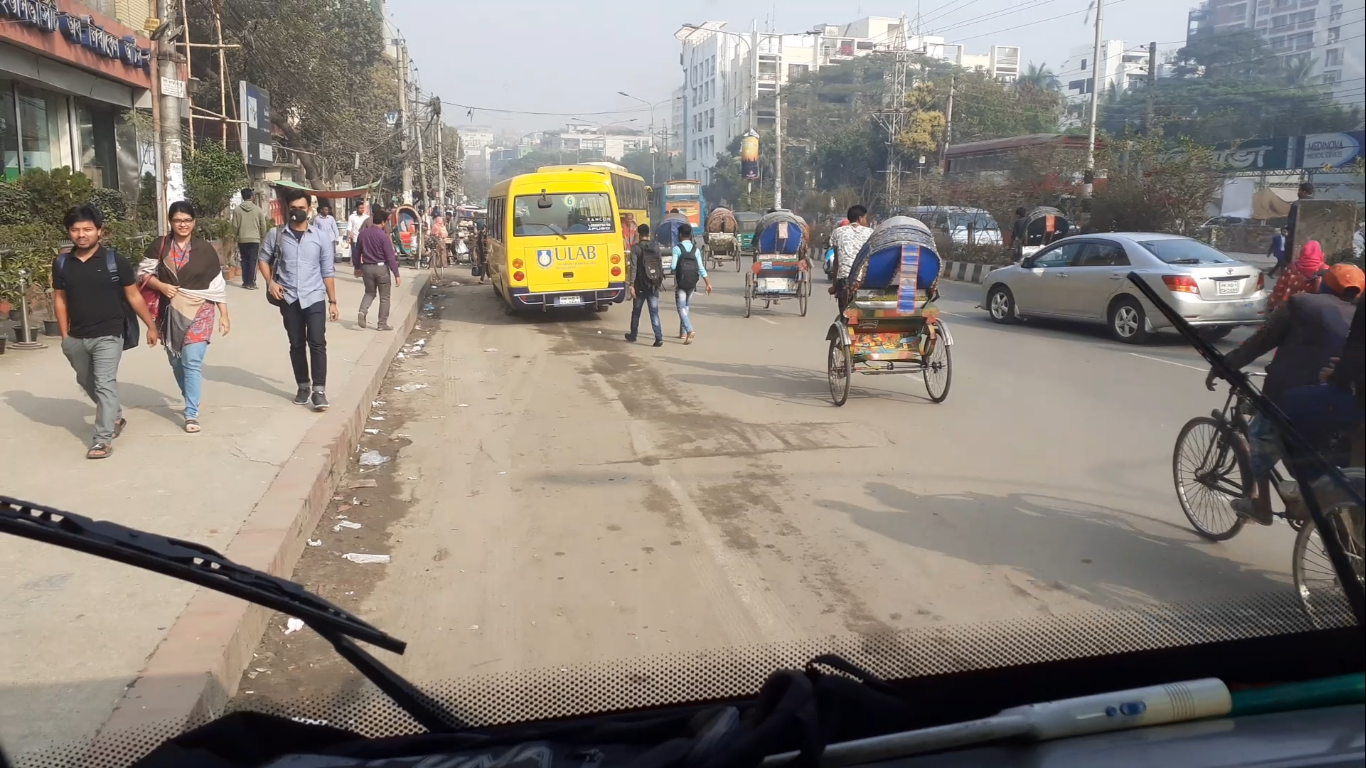

In [ ]:
test_image = images_dir / "193.png"
convert_image(test_image, "test_image.jpg")

display.display(
    Image.open(images_dir / "193.png"),
    Image.open(test_image)  # Add path to the test JPEG

)

For training, YOLO expects a directory structure like so:
```
data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val
```
You may find this surprising.  (Your author certainly did!)  The top-level split is between the images and labels, not between the training and validation sets.

**Task 3.4.10:** Create the directory structure for YOLO training.

In [27]:
yolo_base = pathlib.Path("data_yolo")

# It's important to clear out the directory, if it already
# exists.  We'll get a different train / validation split
# each time, so we need to make sure the old images are
# cleared out.
shutil.rmtree(yolo_base, ignore_errors=True)

(yolo_base / "images" / "train").mkdir(parents=True)
# Create the remaining directories.
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)

!tree $yolo_base

data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


With the directory structure in place, the code below will iterate through all of the images in the original `images_dir`.  It will randomly assign each image either to the training or validation split.  It will parse the annotations file and write it to the correct subdirectory in `data_yolo/labels`.  And it will convert the image into a JPEG and write it to the correct subdirectory in `data_yolo/images`.

Before we run this, and indeed before processing any large set of data, it's worth considering what might go wrong.  We don't want to get 95% of the way through this process and run into an error that forces us to restart.

In this case, the `parse_annotations` function causes us the most worry.  There's all sorts of things that can go wrong with XML parsing, and we haven't written any checks for that yet.

What should we do if we hit an error?  If there are only a few errors in a large data set, that's generally not worth the effort.  We should just skip any files we can't process.  We'll check at the end that we only got a few failures.

**Task 3.4.11:** Add error handling around the `parse_annotations` function call.

In [28]:
train_frac = 0.8
images = list(images_dir.glob("*"))

for img in tqdm(images):
    split = "train" if random.random() < train_frac else "val"

    annotation = annotations_dir / f"{img.stem}.xml"
    # This might raise an error:
    try:
        parsed = parse_annotations(annotation)
    except Exception as e:
        print(f"failed to parse {img.stem}. Skipping!!")
        print(e)
        continue
    dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    write_label(parsed, dest)

    dest = yolo_base / "images" / split / f"{img.stem}.jpg"
    convert_image(img, dest)

  0%|          | 0/3003 [00:00<?, ?it/s]

failed to parse 231. Skipping!!
syntax error: line 1, column 0
failed to parse Pias (360). Skipping!!
float division by zero
failed to parse Pias (359). Skipping!!
float division by zero


Only three errors in three thousand files.  That's 0.1% failure rate, so it's not worth fixing these problems.

Interestingly, only one error was the XML parsing error we expected.  The other two are divide-by-zero errors caused by an image size being incorrectly noted as $0\times0$ pixels.  Catching all exceptions turned out to be a good idea in this case.

**Task 3.4.12:** Check that we ended up with the expected 80/20 split between training and validation.

In [31]:
train_count = len(list((yolo_base / "images" / "train").glob("*")))
val_count = len(list((yolo_base / "images" / "val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

Training fraction:   0.800
Validation fraction: 0.200


<div class="alert alert-info" role="alert">
This technique of randomly assigning each item to a split won't give the exact ratio, but it should be pretty close.
</div>

### Training the Model

The data for training a YOLO model needs to be described in a YAML file.  YAML is a structured document format, somewhat like JSON.  (In fact, YAML is a superset of JSON, so any JSON document is also a valid YAML file.)  Python dictionaries, lists, strings, and numbers map naturally to YAML constructions, so we'll start by defining a dictionary with the necessary keys.

**Task 3.4.13:** Create a dictionary with the appropriate keys for a YOLO data set.

In [32]:
metadata = {
    "path": str(
        yolo_base.absolute()
    ),  # It's easier to specify absolute paths with YOLO.
    
    "train": "images/train", # Training images, relative to above.
    
    "val": "images/val", # Validation images
    
    "names": classes, # Class names, as a list
    
    "nc": len(classes), # Number of classes
}

print(metadata)

{'path': '/app/data_yolo', 'train': 'images/train', 'val': 'images/val', 'names': ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow'], 'nc': 21}


**Task 3.4.14:** Write the YAML file to disk.

In [34]:
yolo_config = "data.yaml"
# Using yaml.safe_dump() protects you from some oddities in the YAML format.
# It takes the same arguments as json.dump().
yaml.safe_dump(metadata, open(yolo_config, "w"))


!cat data.yaml

names:
- ambulance
- army vehicle
- auto rickshaw
- bicycle
- bus
- car
- garbagevan
- human hauler
- minibus
- minivan
- motorbike
- pickup
- policecar
- rickshaw
- scooter
- suv
- taxi
- three wheelers (CNG)
- truck
- van
- wheelbarrow
nc: 21
path: /app/data_yolo
train: images/train
val: images/val


In a previous lesson, we used to `YOLOv8s` (*s* for small) model for object detection.  This time, we'll use the `YOLOv8n` (*n* for nano) model.  The nano model is less than 30% of the size of the small model, but it still manages 80% of the small model's performance.  This'll cut down the training time without hurting performance too much.

In [35]:
model = YOLO("yolov8n.pt")

print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

**Task 3.4.15:** Load the pre-trained model

Load the model that is located at `runs/detect/train/weights/last.pt`.

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

This task involves training the model for more 30 epochs, which might take a long time and your lab might run out of resources. Instead of training it from scratch, load the pre-trained model using the cells below.

<b>Loading the model instead of training it is the only way to pass the activity.</b>
</div>

In [36]:
model = YOLO(model="runs/detect/train/weights/last.pt")

<div class="alert alert-info" role="alert">
    <p><b>Changes with respect to the video</b></p>
<p>The instructor in the video is using <code>results.save_dir</code> to explore the results of the train process, but as we have loaded the model instead of training, we'll need to define a new variable <code>save_dir</code>.</p>
    <p>From now on, any reference that you see to <code>results.save_dir</code> should be replaced with <code>save_dir</code>.</p>
</div>

In [38]:
# Don't change this
save_dir = Path("runs/detect/train")

### Evaluating the Model

During the training process, various diagnostic information is saved to disk.  This is easier to understand than all of that output above.  You can see the directory printed out at the end of the output.  (It will be `runs/detect/train` the first time you run that cell, but will change the next time.)  The directory is also available as a property of the `results` object returned by the `train` function.

In [39]:
print(save_dir)

runs/detect/train


We can use the `tree` command to display the contents of the save directory.

In [40]:
!tree $save_dir

runs/detect/train
├── F1_curve.png
├── PR_curve.png
├── P_curve.png
├── R_curve.png
├── args.yaml
├── confusion_matrix.png
├── confusion_matrix_normalized.png
├── labels.jpg
├── labels_correlogram.jpg
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── train_batch5920.jpg
├── train_batch5921.jpg
├── train_batch5922.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
├── val_batch1_labels.jpg
├── val_batch1_pred.jpg
├── val_batch2_labels.jpg
├── val_batch2_pred.jpg
└── weights
    ├── best.pt
    └── last.pt

1 directory, 25 files


**Task 3.4.16:** Display and examine the precision-recall curves for the model.  They are plotted in `PR_curve.png`.  Remember that the more area under the curve, the better the model is performing.  Which classes does the model do well at detecting?

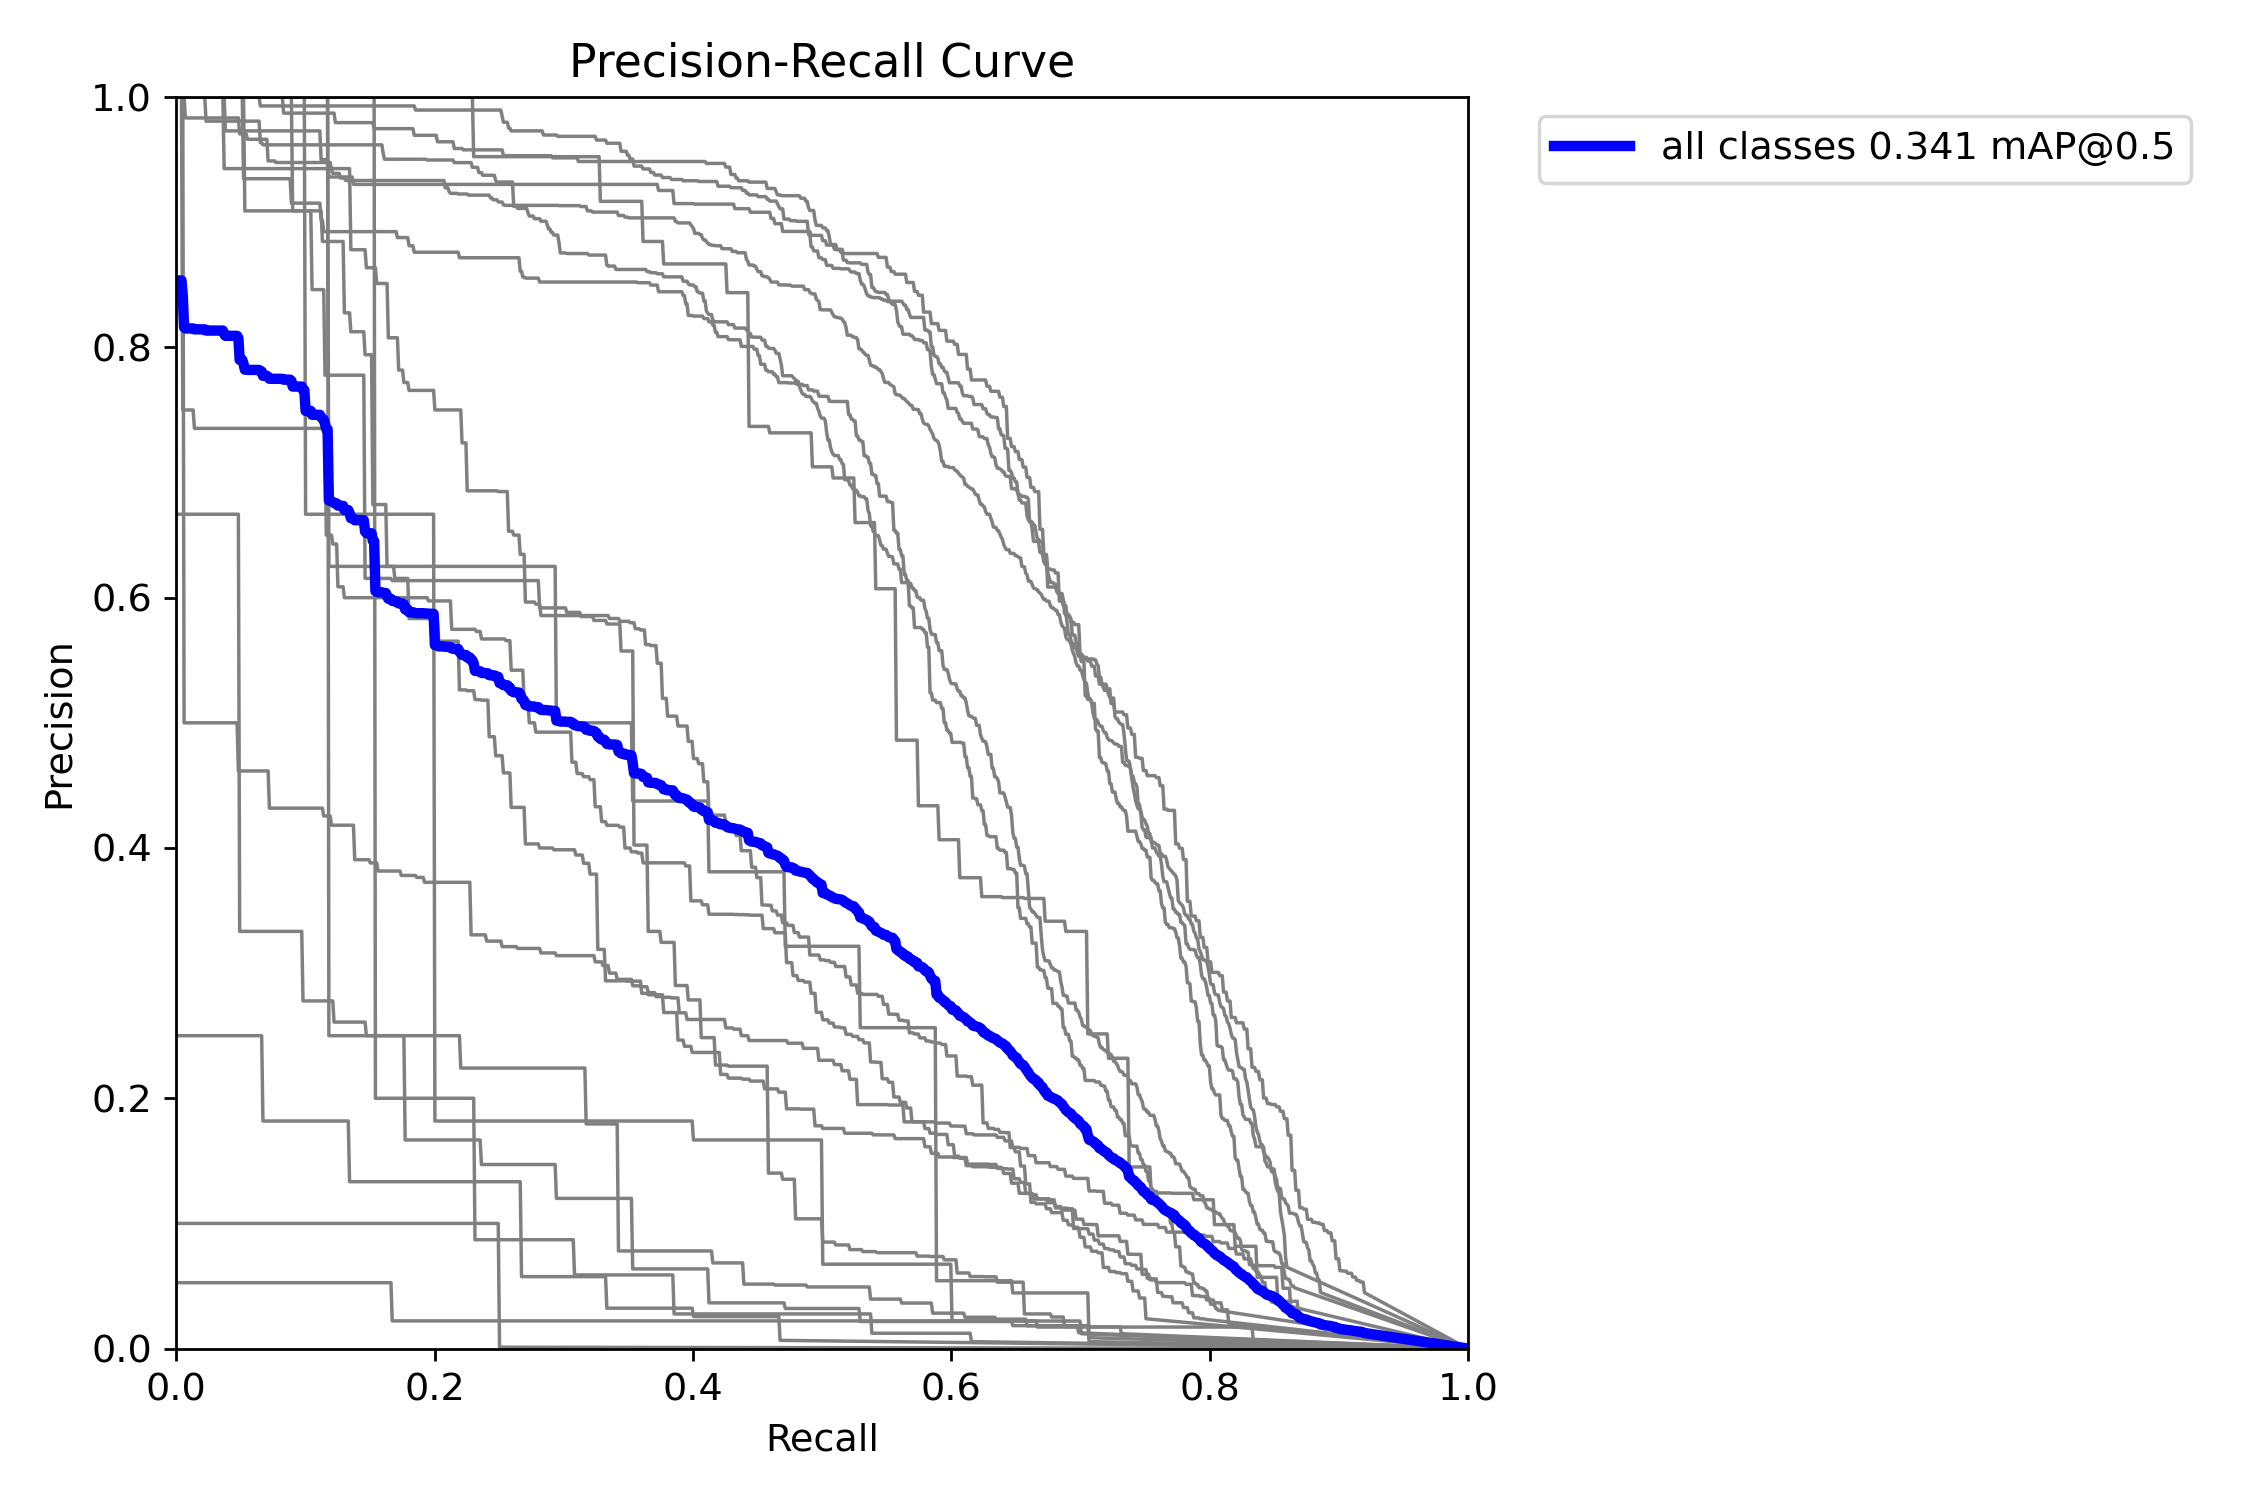

In [43]:
Image.open("runs/detect/train/PR_curve.png")

**Task 3.4.17:** Display the confusion matrix, which is already plotted for us in `confusion_matrix_normalized.png`.  Note which classes the model is most effective on.  Are they the same as those suggested by the precision-recall curves?

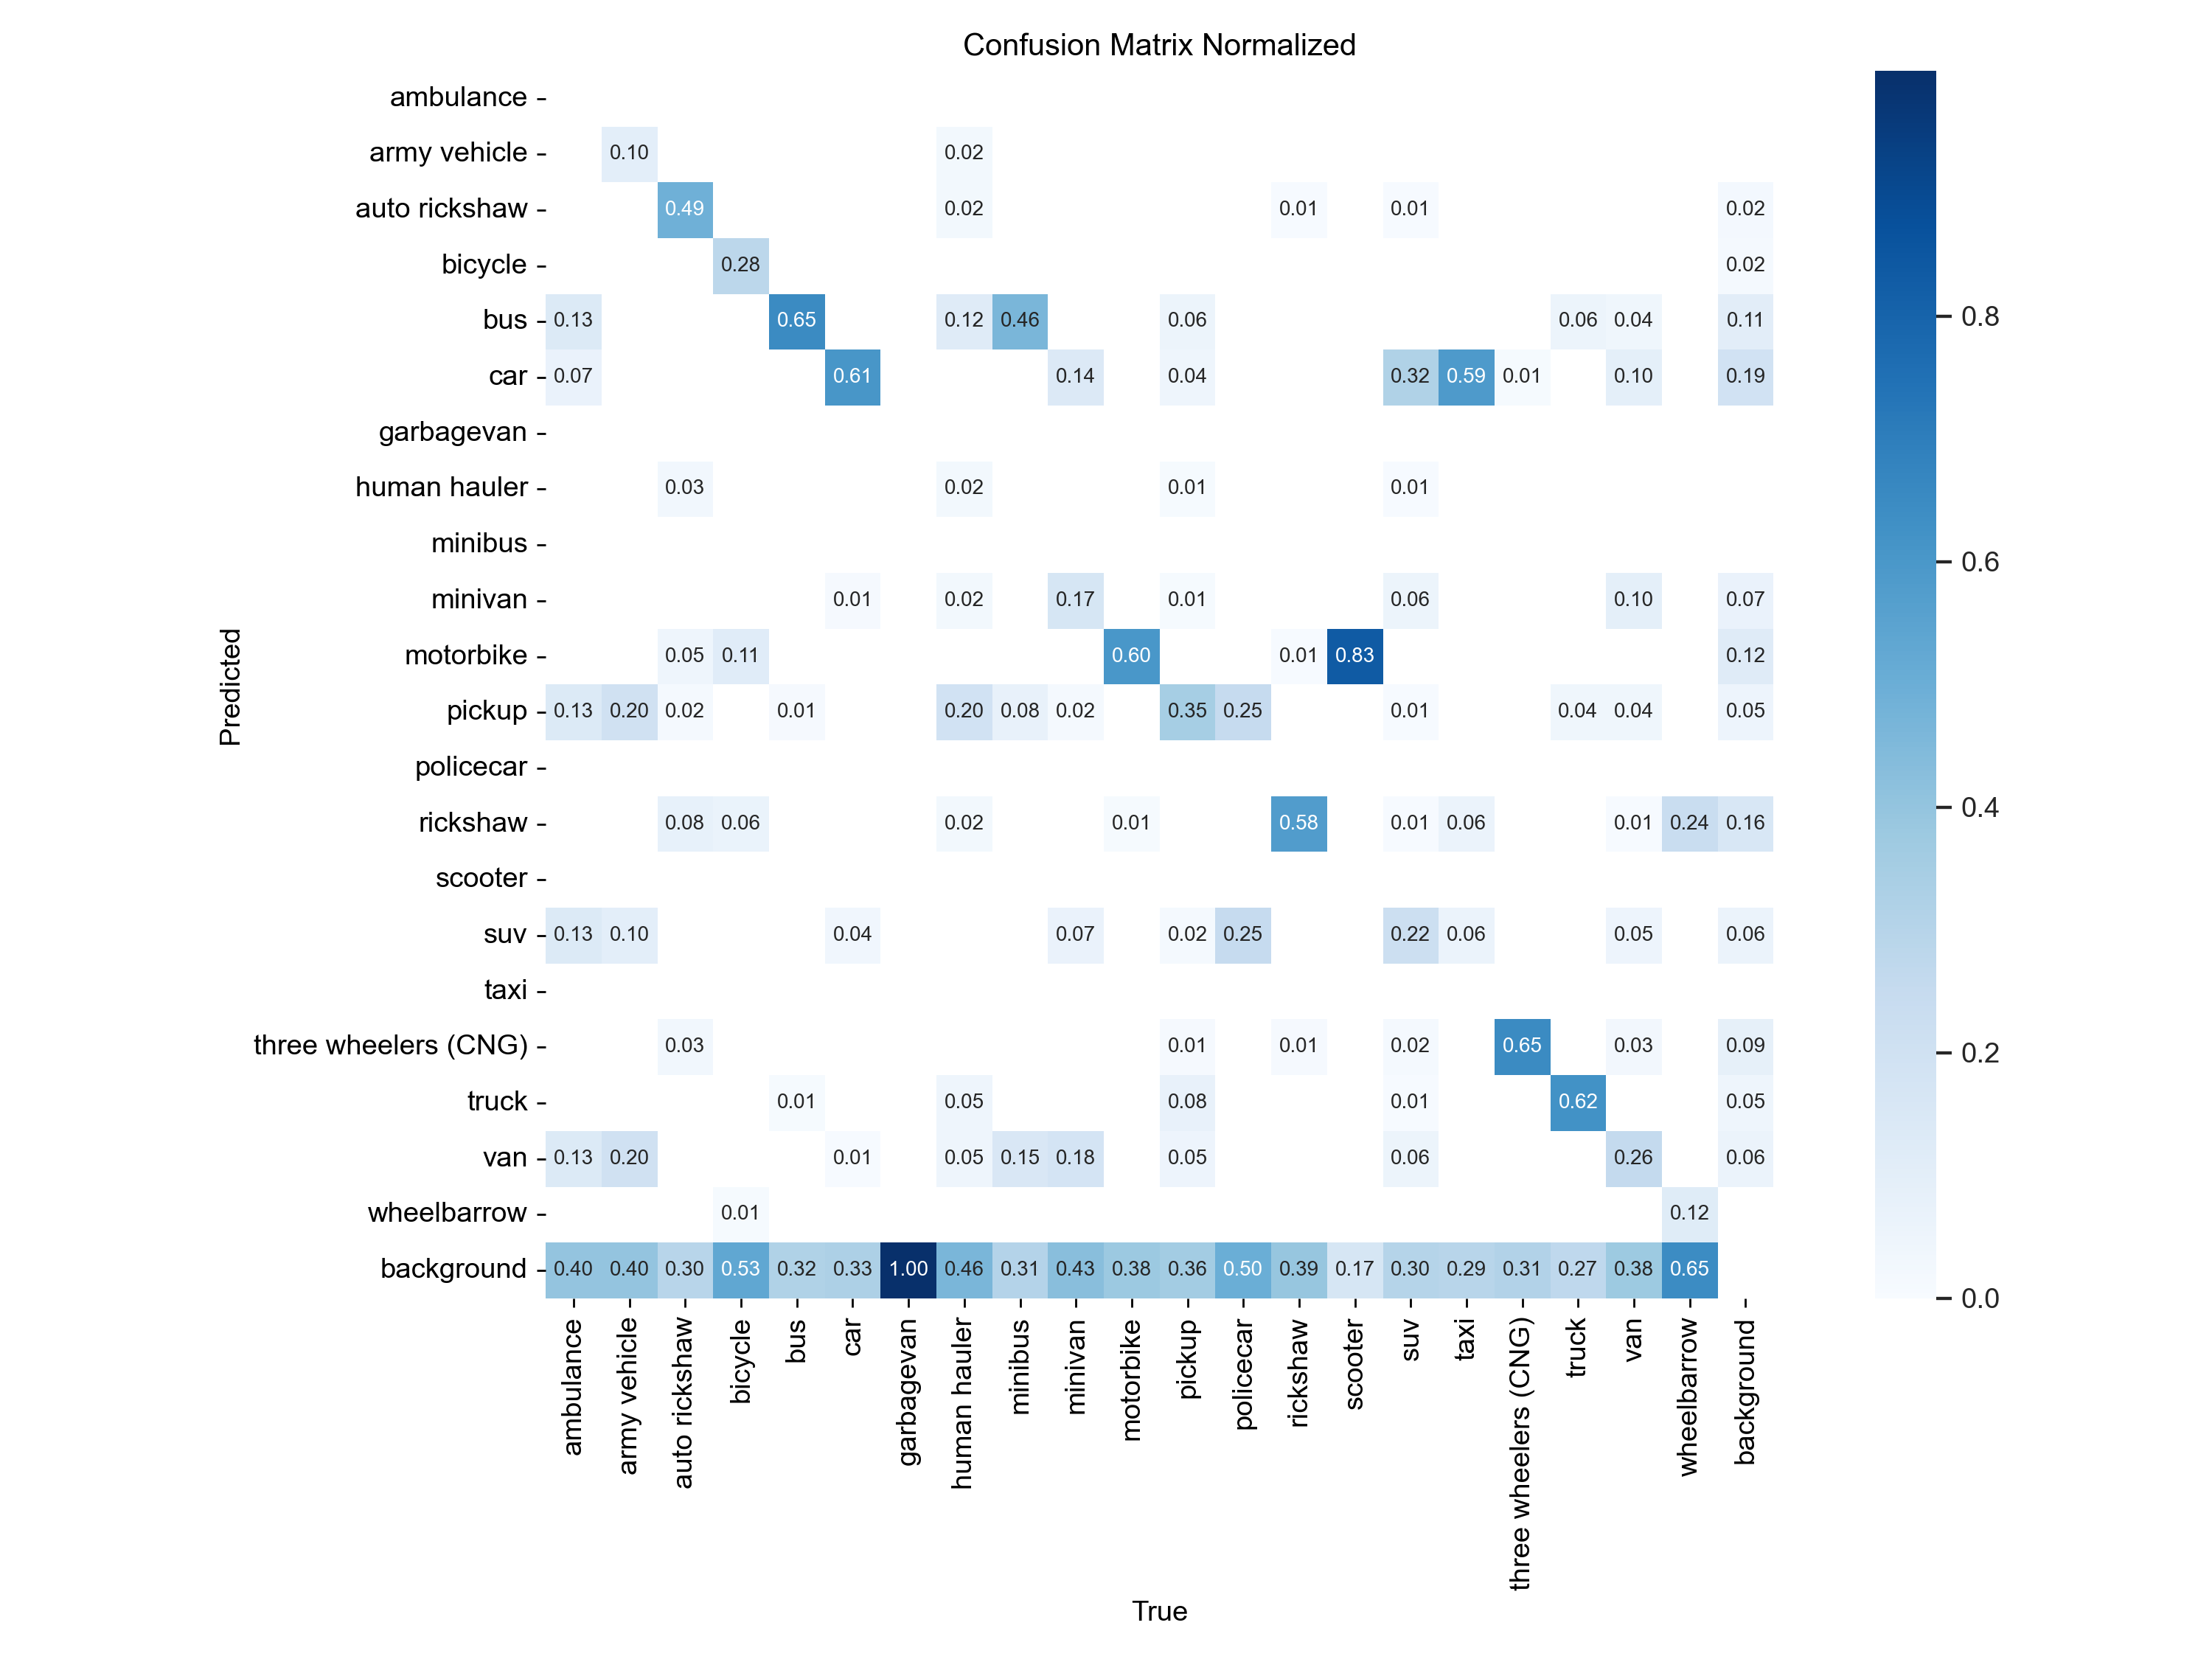

In [44]:
Image.open("runs/detect/train/confusion_matrix_normalized.png")

Data about the training process are available in the `results.csv` file.  We can load it in with pandas, although we need a few options to make the result look nice.

In [45]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index(
    "epoch"
)
df.head()

,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,35.1072,1.45223,3.32406,1.16199,0.59554,0.11979,0.10365,0.06298,1.36083,2.15096,1.11174,0.000133,0.000133,0.000133
2,67.5593,1.42356,2.24330,1.17132,0.67236,0.15496,0.13611,0.08650,1.33130,1.89784,1.10711,0.000257,0.000257,0.000257
3,99.9395,1.38437,2.04035,1.16109,0.56155,0.18055,0.16316,0.10168,1.30970,1.70307,1.10191,0.000373,0.000373,0.000373
4,131.5240,1.36695,1.91453,1.15004,0.60072,0.19290,0.17265,0.10846,1.28410,1.66555,1.08647,0.000360,0.000360,0.000360
5,163.3040,1.32782,1.81436,1.12958,0.55458,0.21755,0.19436,0.12272,1.25971,1.53956,1.07159,0.000347,0.000347,0.000347


**Task 3.4.18:** Plot the classification loss over time for both the training and validation data.  Comparing these curves helps us understand if we are overfitting.

<div class="alert alert-info" role="alert">
<p>Don't see the plot?  Run the code below, and then try the plotting cell again.</p>
<p><pre><code>plt.close('all')
plt.switch_backend('module://matplotlib_inline.backend_inline')</code>
</pre>
<p>This happens with YOLO experiences an error while generating its plots.  It doesn't reset the matplotlib settings correctly.  The code above sets things right again.
</div>

In [46]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


<Axes: xlabel='epoch'>

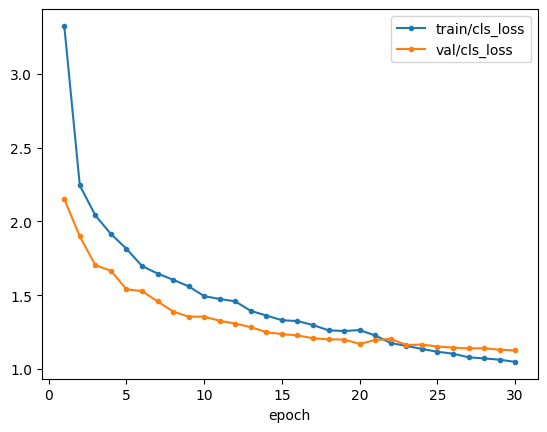

In [48]:
# The `.plot` method on DataFrames may be useful.
df[["train/cls_loss", "val/cls_loss"]].plot(marker=".")

Snapshots of the model are saved in the `weights` subdirectory.  The weights for the last training epoch as well as the best performing epoch, as measured by the validation data, are saved.  This allows us to load the trained model to make predictions.

**Task 3.4.19:** Load the weights that gave the best performance.

In [51]:
saved_model = YOLO(save_dir / "weights" / "best.pt")

print(saved_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

<div class="alert alert-info" role="alert">
Each time you run the predict function loop, YOLO writes out information to <code>runs/detect/predict##</code>.  This can be useful if you want to assemble many results.  If you want to clean up all the old data, run: <code>!rm -r /runs/detect/predict*</code>
</div>

**Task 3.4.20:** Conduct object detection on frame 600 that was extracted from the video.

In [52]:
predict_results = saved_model.predict(
    "data_video/extracted_frames/frame_600.jpg", # Path to an image

    # Only return objects detected at this confidence level or higher
    conf=0.5,
    # Save output to disk
    save=True,
)

f"Results type: {type(predict_results)}, length {len(predict_results)}"


image 1/1 /app/data_video/extracted_frames/frame_600.jpg: 384x640 7 cars, 1 suv, 3 three wheelers (CNG)s, 94.4ms
Speed: 2.1ms preprocess, 94.4ms inference, 172.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


"Results type: <class 'list'>, length 1"

This gives us a list with a single element.  The bounding boxes detected are listed in the `boxes` attribute.

In [53]:
predict_results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 5.,  5., 17.,  5., 17.,  5., 15., 17.,  5.,  5.,  5.], device='cuda:0')
conf: tensor([0.9604, 0.9439, 0.9421, 0.8939, 0.7899, 0.7891, 0.7002, 0.6514, 0.6015, 0.5221, 0.5190], device='cuda:0')
data: tensor([[1.7001e-01, 2.2476e+02, 1.6071e+02, 3.5945e+02, 9.6036e-01, 5.0000e+00],
        [2.6941e+02, 1.5886e+02, 4.6822e+02, 2.9230e+02, 9.4386e-01, 5.0000e+00],
        [5.6848e+02, 1.4075e+02, 5.9965e+02, 1.7218e+02, 9.4212e-01, 1.7000e+01],
        [5.0122e+02, 1.4614e+02, 5.6323e+02, 1.8404e+02, 8.9386e-01, 5.0000e+00],
        [3.6133e+02, 1.2966e+02, 3.8017e+02, 1.4575e+02, 7.8993e-01, 1.7000e+01],
        [4.3392e+02, 1.4806e+02, 4.9631e+02, 2.0146e+02, 7.8912e-01, 5.0000e+00],
        [8.5944e-01, 1.2990e+02, 2.3154e+02, 2.5031e+02, 7.0019e-01, 1.5000e+01],
        [3.0862e+02, 1.3703e+02, 3.6140e+02, 1.7356e+02, 6.5137e-01, 1.7000e+01],
        [2.5644e+02, 1.3687e+02, 3.1232e+02, 1.7165e+02, 6.0147e-01, 5.000

Some properties worth noting:
- `cls` lists the class indices
- `conf` gives the confidence of there being an object
- `xywh` lists the centers and sizes of the bounding boxes in pixels
- `xywhn` gives the same in normalized coordinates.
- `xyxy` and `xyxyn` give the corners of bounding boxes in pixels and normalized coordinate.

**Task 3.4.21:** Get the names of the classes of objects detected in this image.

In [59]:
# Note that the tensor is on the GPU
[classes[int(idx)] for idx in predict_results[0].boxes.cls.cpu()]

['car',
 'car',
 'three wheelers (CNG)',
 'car',
 'three wheelers (CNG)',
 'car',
 'suv',
 'three wheelers (CNG)',
 'car',
 'car',
 'car']

We could use the bounding box information to plot these objects on the image.  But with the `save=True` option we gave the predict call, this image has already been created for us:

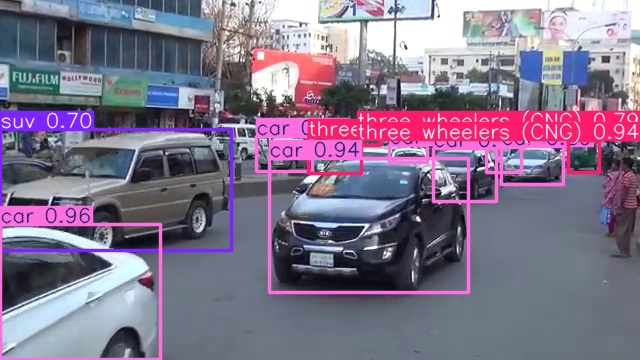

In [60]:
Image.open(pathlib.Path(predict_results[0].save_dir) / "frame_600.jpg")

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).